In [1]:
from fastai.tabular.all import *
from transfertab.utils import *
from transfertab.transfer import *
from transfertab.extract import *
from fastcore.xtras import *
from fastai.learner import *
import torch
import numpy as np
from fastai.interpret import *

In [2]:
import pandas as pd
df = pd.read_csv("../data/bank-additional-full.csv", delimiter=';')

In [3]:
import wandb
from fastai.callback.wandb import *

In [4]:
df.shape

(41188, 21)

In [5]:
41188 * 0.7

28831.6

In [6]:
dfA = df.iloc[0:28831]
dfB = df.iloc[28831:-1]

In [7]:
dfA.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [8]:
contcols = ['age', 'duration', 'campaign', 'pdays',
       'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']
catcols = ['job', 'marital', 'education', 'default', 'housing', 'loan','contact', 
	'month', 'day_of_week','poutcome']
target = 'y'

In [9]:
splitsA = RandomSplitter(valid_pct=0.2)(range_of(dfA))
toA = TabularPandas(dfA, procs=[Categorify, FillMissing, Normalize],
                   cat_names=catcols,
                   cont_names=contcols,
                   y_names=target,
                   splits=splitsA)
dlsA = toA.dataloaders(bs=512)
learnA = tabular_learner(dlsA, metrics=RocAucBinary)

In [10]:
splitsA = RandomSplitter(valid_pct=0.2)(range_of(dfA))
toA = TabularPandas(dfA, procs=[Categorify, FillMissing, Normalize],
                   cat_names=catcols,
                   cont_names=contcols,
                   y_names=target,
                   splits=splitsA)
dlsA = toA.dataloaders(bs=512)
rocaucbin = RocAucBinary()
learnA = tabular_learner(dlsA, metrics=[rocaucbin, accuracy])

In [11]:
wandb.init(
    project='Experiments', 
    save_code=True, 
    group='Exp4c v2', 
    job_type='pretrain', 
    tags=['base', 'bank', 'modelA'], 
    name='modelA training',
    notes="Training modelA from which we'll take embeddings",
    reinit=True,
    dir='/Users/manikyabardhan/Documents/github/transfertab/results/exp4c-v2',
    entity='transfertab'
)

In [12]:
cbs=[WandbCallback(log="all", dataset_name="bank-additional-full (first .7)", n_preds=128, seed=1), SaveModelCallback()]
learnA.fit_one_cycle(50, cbs=cbs)

In [13]:
learnA.recorder.plot_loss()

In [14]:
torch.save(learnA.model.state_dict(),"results/modelA_state_dict")

In [15]:
torch.save(learnA.model.state_dict(),"../results/modelA_state_dict")

In [16]:
torch.save(learnA.model.state_dict(),"../results/exp4c-v2/modelA_state_dict")

In [17]:
catdict = {col:list(learnA.dls.categorify.classes[col]) for col in catcols}

In [18]:
embeds = extractembeds(learnA.model, catdict, transfercats=catcols, allcats=catcols, path="learnA_extracts", kind="json")

In [19]:
wandb.finish()

In [20]:
splitsB = RandomSplitter(valid_pct=0.2)(range_of(dfB))
toB = TabularPandas(dfB, procs=[Categorify, FillMissing, Normalize],
                   cat_names = catcols,
                   cont_names = contcols,
                   y_names=target,
                   splits=splitsB)
dlsB = toB.dataloaders(bs=512)

In [21]:
learnB = tabular_learner(dlsB, metrics=accuracy, emb_szs={'default':4, 'month':12})

In [22]:
# catdict = getcatdict(df, catcols)
metadict = {}
for (cat, classes) in catdict.items():
	metadict[cat] = {'mapped_cat': cat, 'classes_info': {clas: clas for clas in classes}}
with open('bank_meta.json', 'w') as fp:
	json.dump(metadict, fp)

In [23]:
with open('data/json/bank_meta.json', 'r') as fp:
    metadict = json.load(fp) 

In [24]:
with open('../data/json/bank_meta.json', 'r') as fp:
    metadict = json.load(fp) 

In [25]:
with open('../data/jsons/bank_meta.json', 'r') as fp:
    metadict = json.load(fp) 

In [26]:
metadict

{'job': {'mapped_cat': 'job',
  'classes_info': {'#na#': '#na#',
   'admin.': 'admin.',
   'blue-collar': 'blue-collar',
   'entrepreneur': 'entrepreneur',
   'housemaid': 'housemaid',
   'management': 'management',
   'retired': 'retired',
   'self-employed': 'self-employed',
   'services': 'services',
   'student': 'student',
   'technician': 'technician',
   'unemployed': 'unemployed',
   'unknown': 'unknown'}},
 'marital': {'mapped_cat': 'marital',
  'classes_info': {'#na#': '#na#',
   'divorced': 'divorced',
   'married': 'married',
   'single': 'single',
   'unknown': 'unknown'}},
 'education': {'mapped_cat': 'education',
  'classes_info': {'#na#': '#na#',
   'basic.4y': 'basic.4y',
   'basic.6y': 'basic.6y',
   'basic.9y': 'basic.9y',
   'high.school': 'high.school',
   'illiterate': 'illiterate',
   'professional.course': 'professional.course',
   'university.degree': 'university.degree',
   'unknown': 'unknown'}},
 'default': {'mapped_cat': 'default',
  'classes_info': {'#na#'

In [27]:
learnB.dls.categorify['month']

['#na#', 'apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep']

In [28]:
learnA.dls.categorify['month']

['#na#', 'apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct']

In [29]:
learnB.model.embeds

ModuleList(
  (0): Embedding(13, 7)
  (1): Embedding(5, 4)
  (2): Embedding(9, 5)
  (3): Embedding(3, 4)
  (4): Embedding(4, 3)
  (5): Embedding(4, 3)
  (6): Embedding(3, 3)
  (7): Embedding(11, 12)
  (8): Embedding(6, 4)
  (9): Embedding(4, 3)
)

In [30]:
learnB.dls.cat_names

(#10) ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

In [31]:
catcols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [32]:
learnA.dls.categorify['default']

['#na#', 'no', 'unknown', 'yes']

In [33]:
learnB.dls.categorify['default']

['#na#', 'no', 'unknown']

In [34]:
transfercats = ['job',
 'marital',
 'education',
#  'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [35]:
# transfer_cats = (" workclass", " marital_status", " race", " relationship", " education")
# catcolsB = tuple(learnB.dls.cat_names)
# catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcolsB}
transferembeds_(
    learnB.model.embeds, 
    learnA.model.embeds, 
    metadict, 
    transfercats, 
    newcatcols=catcols, 
    oldcatcols=catcols, 
    oldcatdict=catdict, 
    newcatdict=catdict)

In [36]:
transfercats = ['job',
 'marital',
 'education',
#  'default',
 'housing',
 'loan',
 'contact',
#  'month',
 'day_of_week',
 'poutcome']

In [37]:
# transfer_cats = (" workclass", " marital_status", " race", " relationship", " education")
# catcolsB = tuple(learnB.dls.cat_names)
# catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcolsB}
transferembeds_(
    learnB.model.embeds, 
    learnA.model.embeds, 
    metadict, 
    transfercats, 
    newcatcols=catcols, 
    oldcatcols=catcols, 
    oldcatdict=catdict, 
    newcatdict=catdict)

In [38]:
transfercats = ['job',
 'marital',
 'education',
#  'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [39]:
# transfer_cats = (" workclass", " marital_status", " race", " relationship", " education")
# catcolsB = tuple(learnB.dls.cat_names)
# catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcolsB}
transferembeds_(
    learnB.model.embeds, 
    learnA.model.embeds, 
    metadict, 
    transfercats, 
    newcatcols=catcols, 
    oldcatcols=catcols, 
    oldcatdict=catdict, 
    newcatdict=catdict)

In [40]:
learnB = tabular_learner(dlsB, metrics=accuracy, emb_szs={'month':6})

In [41]:
# catdict = getcatdict(df, catcols)
# metadict = {}
# for (cat, classes) in catdict.items():
# 	metadict[cat] = {'mapped_cat': cat, 'classes_info': {clas: clas for clas in classes}}
# with open('bank_meta.json', 'w') as fp:
# 	json.dump(metadict, fp)

In [42]:
# metadict={"job": {"mapped_cat": "job", "classes_info": {"#na#": "#na#", "admin.": "admin.", "blue-collar": "blue-collar", "entrepreneur": "entrepreneur", "housemaid": "housemaid", "management": "management", "retired": "retired", "self-employed": "self-employed", "services": "services", "student": "student", "technician": "technician", "unemployed": "unemployed", "unknown": "unknown"}}, "marital": {"mapped_cat": "marital", "classes_info": {"#na#": "#na#", "divorced": "divorced", "married": "married", "single": "single", "unknown": "unknown"}}, "education": {"mapped_cat": "education", "classes_info": {"#na#": "#na#", "basic.4y": "basic.4y", "basic.6y": "basic.6y", "basic.9y": "basic.9y", "high.school": "high.school", "illiterate": "illiterate", "professional.course": "professional.course", "university.degree": "university.degree", "unknown": "unknown"}}, "default": {"mapped_cat": "default", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown"}}, "housing": {"mapped_cat": "housing", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown", "yes": "yes"}}, "loan": {"mapped_cat": "loan", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown", "yes": "yes"}}, "contact": {"mapped_cat": "contact", "classes_info": {"#na#": "#na#", "cellular": "cellular", "telephone": "telephone"}}, "month": {"mapped_cat": "month", "classes_info": {"#na#": "#na#", "apr": "apr", "aug": "aug", "dec": "dec", "jul": "jul", "jun": "jun", "mar": "mar", "may": "may", "nov": "nov", "oct": "oct", "sep":[]}}, "day_of_week": {"mapped_cat": "day_of_week", "classes_info": {"#na#": "#na#", "fri": "fri", "mon": "mon", "thu": "thu", "tue": "tue", "wed": "wed"}}, "poutcome": {"mapped_cat": "poutcome", "classes_info": {"#na#": "#na#", "failure": "failure", "nonexistent": "nonexistent", "success": "success"}}}

In [43]:
with open('../data/jsons/bank_meta.json', 'r') as fp:
    metadict = json.load(fp) 

In [44]:
metadict

{'job': {'mapped_cat': 'job',
  'classes_info': {'#na#': '#na#',
   'admin.': 'admin.',
   'blue-collar': 'blue-collar',
   'entrepreneur': 'entrepreneur',
   'housemaid': 'housemaid',
   'management': 'management',
   'retired': 'retired',
   'self-employed': 'self-employed',
   'services': 'services',
   'student': 'student',
   'technician': 'technician',
   'unemployed': 'unemployed',
   'unknown': 'unknown'}},
 'marital': {'mapped_cat': 'marital',
  'classes_info': {'#na#': '#na#',
   'divorced': 'divorced',
   'married': 'married',
   'single': 'single',
   'unknown': 'unknown'}},
 'education': {'mapped_cat': 'education',
  'classes_info': {'#na#': '#na#',
   'basic.4y': 'basic.4y',
   'basic.6y': 'basic.6y',
   'basic.9y': 'basic.9y',
   'high.school': 'high.school',
   'illiterate': 'illiterate',
   'professional.course': 'professional.course',
   'university.degree': 'university.degree',
   'unknown': 'unknown'}},
 'default': {'mapped_cat': 'default',
  'classes_info': {'#na#'

In [45]:
learnB.dls.categorify['default']

['#na#', 'no', 'unknown']

In [46]:
learnA.dls.categorify['default']

['#na#', 'no', 'unknown', 'yes']

In [47]:
learnA.model.embeds

ModuleList(
  (0): Embedding(13, 7)
  (1): Embedding(5, 4)
  (2): Embedding(9, 5)
  (3): Embedding(4, 3)
  (4): Embedding(4, 3)
  (5): Embedding(4, 3)
  (6): Embedding(3, 3)
  (7): Embedding(10, 6)
  (8): Embedding(6, 4)
  (9): Embedding(4, 3)
)

In [48]:
learnB.model.embeds

ModuleList(
  (0): Embedding(13, 7)
  (1): Embedding(5, 4)
  (2): Embedding(9, 5)
  (3): Embedding(3, 3)
  (4): Embedding(4, 3)
  (5): Embedding(4, 3)
  (6): Embedding(3, 3)
  (7): Embedding(11, 6)
  (8): Embedding(6, 4)
  (9): Embedding(4, 3)
)

In [49]:
learnB.dls.cat_names

(#10) ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

In [50]:
transfercats = ['job',
 'marital',
 'education',
#  'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [51]:
# transfer_cats = (" workclass", " marital_status", " race", " relationship", " education")
# catcolsB = tuple(learnB.dls.cat_names)
# catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcolsB}
transferembeds_(
    learnB.model.embeds, 
    learnA.model.embeds, 
    metadict, 
    transfercats, 
    newcatcols=catcols, 
    oldcatcols=catcols, 
    oldcatdict=catdict, 
    newcatdict=catdict)

In [52]:
catdictA = {col:list(learnA.dls.categorify.classes[col]) for col in catcols}

In [53]:
catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcols}

In [54]:
# transfer_cats = (" workclass", " marital_status", " race", " relationship", " education")
# catcolsB = tuple(learnB.dls.cat_names)
# catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcolsB}
transferembeds_(
    learnB.model.embeds, 
    learnA.model.embeds, 
    metadict, 
    transfercats, 
    newcatcols=catcols, 
    oldcatcols=catcols, 
    oldcatdict=catdictA, 
    newcatdict=catdictB)

In [55]:
transfercats = ['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [56]:
catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcols}

In [57]:
# transfer_cats = (" workclass", " marital_status", " race", " relationship", " education")
# catcolsB = tuple(learnB.dls.cat_names)
# catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcolsB}
transferembeds_(
    learnB.model.embeds, 
    learnA.model.embeds, 
    metadict, 
    transfercats, 
    newcatcols=catcols, 
    oldcatcols=catcols, 
    oldcatdict=catdictA, 
    newcatdict=catdictB)

In [58]:
learnA.model.embeds[catcols.index('marital')].weight

Parameter containing:
tensor([[-0.0041,  0.0100,  0.0102, -0.0024],
        [ 0.0009,  0.0190,  0.0418,  0.0202],
        [-0.0319,  0.0140, -0.0415, -0.0403],
        [ 0.0654, -0.0346, -0.0149,  0.0547],
        [-0.0699, -0.0018, -0.0980,  0.0875]], requires_grad=True)

In [59]:
learnB.model.embeds[catcols.index('marital')].weight

Parameter containing:
tensor([[-0.0041,  0.0100,  0.0102, -0.0024],
        [ 0.0009,  0.0190,  0.0418,  0.0202],
        [-0.0319,  0.0140, -0.0415, -0.0403],
        [ 0.0654, -0.0346, -0.0149,  0.0547],
        [-0.0699, -0.0018, -0.0980,  0.0875]], requires_grad=True)

In [60]:
rocaucbinB = RocAucBinary()
learnB = tabular_learner(dlsB, metrics=[rocaucbinB, accuracy], emb_szs={'month':6})

In [61]:
# catdict = getcatdict(df, catcols)
# metadict = {}
# for (cat, classes) in catdict.items():
# 	metadict[cat] = {'mapped_cat': cat, 'classes_info': {clas: clas for clas in classes}}
# with open('bank_meta.json', 'w') as fp:
# 	json.dump(metadict, fp)

In [62]:
# metadict={"job": {"mapped_cat": "job", "classes_info": {"#na#": "#na#", "admin.": "admin.", "blue-collar": "blue-collar", "entrepreneur": "entrepreneur", "housemaid": "housemaid", "management": "management", "retired": "retired", "self-employed": "self-employed", "services": "services", "student": "student", "technician": "technician", "unemployed": "unemployed", "unknown": "unknown"}}, "marital": {"mapped_cat": "marital", "classes_info": {"#na#": "#na#", "divorced": "divorced", "married": "married", "single": "single", "unknown": "unknown"}}, "education": {"mapped_cat": "education", "classes_info": {"#na#": "#na#", "basic.4y": "basic.4y", "basic.6y": "basic.6y", "basic.9y": "basic.9y", "high.school": "high.school", "illiterate": "illiterate", "professional.course": "professional.course", "university.degree": "university.degree", "unknown": "unknown"}}, "default": {"mapped_cat": "default", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown"}}, "housing": {"mapped_cat": "housing", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown", "yes": "yes"}}, "loan": {"mapped_cat": "loan", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown", "yes": "yes"}}, "contact": {"mapped_cat": "contact", "classes_info": {"#na#": "#na#", "cellular": "cellular", "telephone": "telephone"}}, "month": {"mapped_cat": "month", "classes_info": {"#na#": "#na#", "apr": "apr", "aug": "aug", "dec": "dec", "jul": "jul", "jun": "jun", "mar": "mar", "may": "may", "nov": "nov", "oct": "oct", "sep":[]}}, "day_of_week": {"mapped_cat": "day_of_week", "classes_info": {"#na#": "#na#", "fri": "fri", "mon": "mon", "thu": "thu", "tue": "tue", "wed": "wed"}}, "poutcome": {"mapped_cat": "poutcome", "classes_info": {"#na#": "#na#", "failure": "failure", "nonexistent": "nonexistent", "success": "success"}}}

In [63]:
with open('../data/jsons/bank_meta.json', 'r') as fp:
    metadict = json.load(fp) 

In [64]:
metadict

{'job': {'mapped_cat': 'job',
  'classes_info': {'#na#': '#na#',
   'admin.': 'admin.',
   'blue-collar': 'blue-collar',
   'entrepreneur': 'entrepreneur',
   'housemaid': 'housemaid',
   'management': 'management',
   'retired': 'retired',
   'self-employed': 'self-employed',
   'services': 'services',
   'student': 'student',
   'technician': 'technician',
   'unemployed': 'unemployed',
   'unknown': 'unknown'}},
 'marital': {'mapped_cat': 'marital',
  'classes_info': {'#na#': '#na#',
   'divorced': 'divorced',
   'married': 'married',
   'single': 'single',
   'unknown': 'unknown'}},
 'education': {'mapped_cat': 'education',
  'classes_info': {'#na#': '#na#',
   'basic.4y': 'basic.4y',
   'basic.6y': 'basic.6y',
   'basic.9y': 'basic.9y',
   'high.school': 'high.school',
   'illiterate': 'illiterate',
   'professional.course': 'professional.course',
   'university.degree': 'university.degree',
   'unknown': 'unknown'}},
 'default': {'mapped_cat': 'default',
  'classes_info': {'#na#'

In [65]:
learnB.dls.categorify['default']

['#na#', 'no', 'unknown']

In [66]:
learnA.dls.categorify['default']

['#na#', 'no', 'unknown', 'yes']

In [67]:
learnA.model.embeds

ModuleList(
  (0): Embedding(13, 7)
  (1): Embedding(5, 4)
  (2): Embedding(9, 5)
  (3): Embedding(4, 3)
  (4): Embedding(4, 3)
  (5): Embedding(4, 3)
  (6): Embedding(3, 3)
  (7): Embedding(10, 6)
  (8): Embedding(6, 4)
  (9): Embedding(4, 3)
)

In [68]:
learnB.model.embeds

ModuleList(
  (0): Embedding(13, 7)
  (1): Embedding(5, 4)
  (2): Embedding(9, 5)
  (3): Embedding(3, 3)
  (4): Embedding(4, 3)
  (5): Embedding(4, 3)
  (6): Embedding(3, 3)
  (7): Embedding(11, 6)
  (8): Embedding(6, 4)
  (9): Embedding(4, 3)
)

In [69]:
learnB.dls.cat_names

(#10) ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

In [70]:
transfercats = ['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [71]:
catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcols}

In [72]:
# transfer_cats = (" workclass", " marital_status", " race", " relationship", " education")
# catcolsB = tuple(learnB.dls.cat_names)
# catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcolsB}
transferembeds_(
    learnB.model.embeds, 
    learnA.model.embeds, 
    metadict, 
    transfercats, 
    newcatcols=catcols, 
    oldcatcols=catcols, 
    oldcatdict=catdictA, 
    newcatdict=catdictB)

In [73]:
learnA.model.embeds[catcols.index('marital')].weight

Parameter containing:
tensor([[-0.0041,  0.0100,  0.0102, -0.0024],
        [ 0.0009,  0.0190,  0.0418,  0.0202],
        [-0.0319,  0.0140, -0.0415, -0.0403],
        [ 0.0654, -0.0346, -0.0149,  0.0547],
        [-0.0699, -0.0018, -0.0980,  0.0875]], requires_grad=True)

In [74]:
learnB.model.embeds[catcols.index('marital')].weight

Parameter containing:
tensor([[-0.0041,  0.0100,  0.0102, -0.0024],
        [ 0.0009,  0.0190,  0.0418,  0.0202],
        [-0.0319,  0.0140, -0.0415, -0.0403],
        [ 0.0654, -0.0346, -0.0149,  0.0547],
        [-0.0699, -0.0018, -0.0980,  0.0875]], requires_grad=True)

In [75]:
dlsC = deepcopy(dlsB)
rocaucbinC = RocAucBinary()
learnC = tabular_learner(dlsC, metrics=[rocaucbinC, accuracy], emb_szs={'month':6})

In [76]:
learnC.model.layers.load_state_dict(learnB.model.layers.state_dict())

<All keys matched successfully>

In [77]:
wandb.init(
    project='Experiments',
    entity='transfertab',
    save_code=True, 
    group='Exp4c v2', 
    job_type='finetune', 
    tags=['transfer', 'bank', 'modelB'], 
    name='modelB training',
    notes='Training modelB which contains transferred embeddings',
    reinit=True,
    dir='/Users/manikyabardhan/Documents/github/transfertab/results/exp4c-v2'
)

In [78]:
for i in range(len(catcols)):
    learnB.model.embeds[i].weight.requires_grad = False
learnB.create_opt()

In [79]:
learnB.embeds[5].weight

Parameter containing:
tensor([[ 0.0012, -0.0142, -0.0104],
        [-0.0150,  0.0564, -0.0425],
        [-0.0274,  0.0058, -0.0065],
        [ 0.0386, -0.0425,  0.0627]])

In [80]:
cbsB=[WandbCallback(log="all", dataset_name="bank 0.3%", n_preds=128, seed=1), SaveModelCallback()]
learnB.fit_one_cycle(3, cbs=cbsB)

In [81]:
wandb.finish()

In [82]:
wandb.init(
    project='Experiments',
    entity='transfertab',
    save_code=True, 
    group='Exp4c v2', 
    job_type='finetune', 
    tags=['transfer', 'bank', 'modelB'], 
    name='modelB training',
    notes='Training modelB which contains transferred embeddings',
    reinit=True,
    dir='/Users/manikyabardhan/Documents/github/transfertab/results/exp4c-v2'
)

In [83]:
splitsB = RandomSplitter(valid_pct=0.2)(range_of(dfB))
toB = TabularPandas(dfB, procs=[Categorify, FillMissing, Normalize],
                   cat_names = catcols,
                   cont_names = contcols,
                   y_names=target,
                   splits=splitsB)
dlsB = toB.dataloaders(bs=512)

In [84]:
rocaucbinB = RocAucBinary()
learnB = tabular_learner(dlsB, metrics=[rocaucbinB, accuracy], emb_szs={'month':6})

In [85]:
# catdict = getcatdict(df, catcols)
# metadict = {}
# for (cat, classes) in catdict.items():
# 	metadict[cat] = {'mapped_cat': cat, 'classes_info': {clas: clas for clas in classes}}
# with open('bank_meta.json', 'w') as fp:
# 	json.dump(metadict, fp)

In [86]:
# metadict={"job": {"mapped_cat": "job", "classes_info": {"#na#": "#na#", "admin.": "admin.", "blue-collar": "blue-collar", "entrepreneur": "entrepreneur", "housemaid": "housemaid", "management": "management", "retired": "retired", "self-employed": "self-employed", "services": "services", "student": "student", "technician": "technician", "unemployed": "unemployed", "unknown": "unknown"}}, "marital": {"mapped_cat": "marital", "classes_info": {"#na#": "#na#", "divorced": "divorced", "married": "married", "single": "single", "unknown": "unknown"}}, "education": {"mapped_cat": "education", "classes_info": {"#na#": "#na#", "basic.4y": "basic.4y", "basic.6y": "basic.6y", "basic.9y": "basic.9y", "high.school": "high.school", "illiterate": "illiterate", "professional.course": "professional.course", "university.degree": "university.degree", "unknown": "unknown"}}, "default": {"mapped_cat": "default", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown"}}, "housing": {"mapped_cat": "housing", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown", "yes": "yes"}}, "loan": {"mapped_cat": "loan", "classes_info": {"#na#": "#na#", "no": "no", "unknown": "unknown", "yes": "yes"}}, "contact": {"mapped_cat": "contact", "classes_info": {"#na#": "#na#", "cellular": "cellular", "telephone": "telephone"}}, "month": {"mapped_cat": "month", "classes_info": {"#na#": "#na#", "apr": "apr", "aug": "aug", "dec": "dec", "jul": "jul", "jun": "jun", "mar": "mar", "may": "may", "nov": "nov", "oct": "oct", "sep":[]}}, "day_of_week": {"mapped_cat": "day_of_week", "classes_info": {"#na#": "#na#", "fri": "fri", "mon": "mon", "thu": "thu", "tue": "tue", "wed": "wed"}}, "poutcome": {"mapped_cat": "poutcome", "classes_info": {"#na#": "#na#", "failure": "failure", "nonexistent": "nonexistent", "success": "success"}}}

In [87]:
with open('../data/jsons/bank_meta.json', 'r') as fp:
    metadict = json.load(fp) 

In [88]:
metadict

{'job': {'mapped_cat': 'job',
  'classes_info': {'#na#': '#na#',
   'admin.': 'admin.',
   'blue-collar': 'blue-collar',
   'entrepreneur': 'entrepreneur',
   'housemaid': 'housemaid',
   'management': 'management',
   'retired': 'retired',
   'self-employed': 'self-employed',
   'services': 'services',
   'student': 'student',
   'technician': 'technician',
   'unemployed': 'unemployed',
   'unknown': 'unknown'}},
 'marital': {'mapped_cat': 'marital',
  'classes_info': {'#na#': '#na#',
   'divorced': 'divorced',
   'married': 'married',
   'single': 'single',
   'unknown': 'unknown'}},
 'education': {'mapped_cat': 'education',
  'classes_info': {'#na#': '#na#',
   'basic.4y': 'basic.4y',
   'basic.6y': 'basic.6y',
   'basic.9y': 'basic.9y',
   'high.school': 'high.school',
   'illiterate': 'illiterate',
   'professional.course': 'professional.course',
   'university.degree': 'university.degree',
   'unknown': 'unknown'}},
 'default': {'mapped_cat': 'default',
  'classes_info': {'#na#'

In [89]:
learnB.dls.categorify['default']

['#na#', 'no', 'unknown']

In [90]:
learnA.dls.categorify['default']

['#na#', 'no', 'unknown', 'yes']

In [91]:
learnA.model.embeds

ModuleList(
  (0): Embedding(13, 7)
  (1): Embedding(5, 4)
  (2): Embedding(9, 5)
  (3): Embedding(4, 3)
  (4): Embedding(4, 3)
  (5): Embedding(4, 3)
  (6): Embedding(3, 3)
  (7): Embedding(10, 6)
  (8): Embedding(6, 4)
  (9): Embedding(4, 3)
)

In [92]:
learnB.model.embeds

ModuleList(
  (0): Embedding(13, 7)
  (1): Embedding(5, 4)
  (2): Embedding(9, 5)
  (3): Embedding(3, 3)
  (4): Embedding(4, 3)
  (5): Embedding(4, 3)
  (6): Embedding(3, 3)
  (7): Embedding(11, 6)
  (8): Embedding(6, 4)
  (9): Embedding(4, 3)
)

In [93]:
learnB.dls.cat_names

(#10) ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

In [94]:
transfercats = ['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [95]:
catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcols}

In [96]:
# transfer_cats = (" workclass", " marital_status", " race", " relationship", " education")
# catcolsB = tuple(learnB.dls.cat_names)
# catdictB = {col:list(learnB.dls.categorify.classes[col]) for col in catcolsB}
transferembeds_(
    learnB.model.embeds, 
    learnA.model.embeds, 
    metadict, 
    transfercats, 
    newcatcols=catcols, 
    oldcatcols=catcols, 
    oldcatdict=catdictA, 
    newcatdict=catdictB)

In [97]:
learnA.model.embeds[catcols.index('marital')].weight

Parameter containing:
tensor([[-0.0041,  0.0100,  0.0102, -0.0024],
        [ 0.0009,  0.0190,  0.0418,  0.0202],
        [-0.0319,  0.0140, -0.0415, -0.0403],
        [ 0.0654, -0.0346, -0.0149,  0.0547],
        [-0.0699, -0.0018, -0.0980,  0.0875]], requires_grad=True)

In [98]:
learnB.model.embeds[catcols.index('marital')].weight

Parameter containing:
tensor([[-0.0041,  0.0100,  0.0102, -0.0024],
        [ 0.0009,  0.0190,  0.0418,  0.0202],
        [-0.0319,  0.0140, -0.0415, -0.0403],
        [ 0.0654, -0.0346, -0.0149,  0.0547],
        [-0.0699, -0.0018, -0.0980,  0.0875]], requires_grad=True)

In [99]:
dlsC = deepcopy(dlsB)
rocaucbinC = RocAucBinary()
learnC = tabular_learner(dlsC, metrics=[rocaucbinC, accuracy], emb_szs={'month':6})

In [100]:
learnC.model.layers.load_state_dict(learnB.model.layers.state_dict())

<All keys matched successfully>

In [101]:
for i in range(len(catcols)):
    learnB.model.embeds[i].weight.requires_grad = False
learnB.create_opt()

In [102]:
learnB.embeds[5].weight

Parameter containing:
tensor([[ 0.0012, -0.0142, -0.0104],
        [-0.0150,  0.0564, -0.0425],
        [-0.0274,  0.0058, -0.0065],
        [ 0.0386, -0.0425,  0.0627]])

In [103]:
cbsB=[WandbCallback(log="all", dataset_name="bank 0.3%", n_preds=128, seed=1)]
learnB.fit_one_cycle(3, cbs=cbsB)

In [104]:
for i in range(len(catcols)):
    learnB.model.embeds[i].weight.requires_grad = True
learnB.create_opt()

In [105]:
learnB.fit_one_cycle(5, cbs=cbsB)

In [106]:
learnB.recorder.plot_loss()

In [107]:
wandb.finish()

In [108]:
wandb.init(
    project='Experiments',
    entity='transfertab',
    save_code=True, 
    group='Exp4c v2', 
    job_type='controlgrp',
    tags=['base', 'bank', 'modelC'], 
    name='modelC training',
    notes='Training modelC which contains randomly initialized weights and same classifier weights as modelB',
    reinit=True,
    dir='/Users/manikyabardhan/Documents/github/transfertab/results/exp4c-v2'
)

In [109]:
cbsC=[WandbCallback(log="all", dataset_name="bank 0.3%", n_preds=128, seed=1)]
learnC.fit_one_cycle(8, cbs=cbsC)

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07


epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.608667,0.660277,0.857243,0.683124,00:00
1,0.559486,0.533128,0.879744,0.800081,00:06
2,0.520422,0.478313,0.886226,0.808175,00:06
3,0.488429,0.467712,0.879713,0.820720,00:06
4,0.460895,0.446551,0.882524,0.814245,00:06
5,0.437998,0.426298,0.890396,0.826386,00:06
6,0.419734,0.429554,0.888822,0.821125,00:07
7,0.406062,0.427293,0.889090,0.821934,00:06


In [110]:
learnC.recorder.plot_loss()

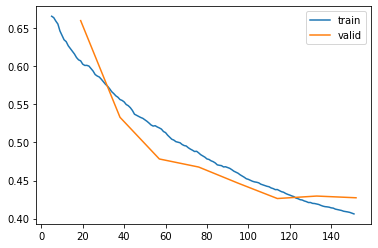

In [111]:
wandb.finish()